# Interchange Interventions on Neural Networks

This notebook demonstrates how to run **interchange interventions** on actual neural networks to test causal hypotheses about entity binding. This bridges the gap between the theoretical causal models (notebooks 01-03) and running real experiments on LLMs.

## The Experiment: Answer vs Answer Pointer

When a model answers "Who loves pie?" with "Ann", is it storing:
1. **The semantic answer** (`raw_output`): The actual entity "Ann"
2. **A positional pointer** (`positional_answer`): "Look up the answer from group 1"

We test this by creating counterfactual pairs where entities swap positions, then patching activations from the counterfactual into the original. If the model uses positional lookup, patching the position information should change the output.

## Setup

- **Query**: food (index 1) - "Who loves {food}?"
- **Answer**: person (index 0) - expects a person name
- **Counterfactual**: Different answer (change_answer=True)
- **Target variables**: `positional_answer` vs `raw_output`

In [1]:
%load_ext autoreload
%autoreload 2

import torch
from pathlib import Path
import tempfile

from causalab.tasks.entity_binding.causal_models import create_positional_entity_causal_model
from causalab.tasks.entity_binding.counterfactuals import swap_query_group
from causalab.tasks.entity_binding.experiment_config import get_task_config, get_checker

from causalab.causal.causal_utils import generate_counterfactual_samples, save_counterfactual_examples
from causalab.experiments.filter import filter_dataset
from causalab.experiments.interchange_targets import build_residual_stream_targets
from causalab.experiments.jobs.interchange_score_grid import run_interchange_score_heatmap

from causalab.neural.pipeline import LMPipeline
from causalab.neural.token_position_builder import build_token_position_factories

In [2]:
# Experiment configuration
EXPERIMENT_CONFIG = {
    "model_name": "Qwen/Qwen3-8B",
    "query_indices": (1,),      # Query food
    "answer_index": 0,          # Answer is person
    "change_answer": True,      # Counterfactual has different answer
    "dataset_size": 128,
    "batch_size": 32,
    "target_variables": ["positional_answer", "raw_output"],
}

# Device setup
device = "cuda" if torch.cuda.is_available() else "cpu"
dtype = torch.bfloat16 if device == "cuda" else torch.float32

print(f"Device: {device}")
print(f"Dtype: {dtype}")

Device: cuda
Dtype: torch.bfloat16


In [3]:
# Load the language model
print(f"Loading {EXPERIMENT_CONFIG['model_name']}...")

pipeline = LMPipeline(
    EXPERIMENT_CONFIG["model_name"],
    max_new_tokens=5,
    device=device,
    dtype=dtype,
    max_length=256,
)
pipeline.tokenizer.padding_side = "left"

num_layers = pipeline.model.config.num_hidden_layers
print(f"Model loaded with {num_layers} layers")

Loading Qwen/Qwen3-8B...


`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Model loaded with 36 layers


## Part 2: Create Causal Model

The **positional entity causal model** represents the hypothesis that the model:
1. Searches for the query entity in stored bindings
2. Finds which group (position) contains that entity
3. Retrieves the answer from that position

Key variables:
- `positional_query_e{i}`: Groups where query entity appears at position i
- `positional_answer`: The group position to retrieve from (intersection of positional queries)
- `raw_output`: The actual answer retrieved

In [4]:
# Create task config with fixed query/answer indices
task_config = get_task_config("love")
task_config.fixed_query_indices = EXPERIMENT_CONFIG["query_indices"]
task_config.fixed_answer_index = EXPERIMENT_CONFIG["answer_index"]

# Create causal model
causal_model = create_positional_entity_causal_model(task_config)

print(f"Causal model: {causal_model.id}")
print(f"Total variables: {len(causal_model.variables)}")
print(f"\nKey positional variables:")
positional_vars = [v for v in causal_model.variables if v.startswith("positional_")]
for v in positional_vars:
    print(f"  - {v}")

Causal model: entity_binding_positional_entity_2g_2e
Total variables: 22

Key positional variables:
  - positional_entity_g0_e0
  - positional_entity_g0_e1
  - positional_entity_g1_e0
  - positional_entity_g1_e1
  - positional_query_e0
  - positional_query_e1
  - positional_answer


## Part 3: Generate Counterfactual Dataset

We use `swap_query_group` to create counterfactual pairs where entity groups are swapped.

With `change_answer=True`:
- Original: "Pete loves pie and Ann loves cake. Who loves pie?" → "Pete"
- Counterfactual: "Ann loves cake and Pete loves pie. Who loves cake?" → "Ann"

The counterfactual changes which entity is queried, so the answer changes too. This allows us to test whether patching `positional_answer` from the counterfactual changes the output to match the counterfactual's answer.

In [5]:
# Generate counterfactual dataset
def generator():
    return swap_query_group(task_config, change_answer=EXPERIMENT_CONFIG["change_answer"])

dataset = generate_counterfactual_samples(EXPERIMENT_CONFIG["dataset_size"], generator)
print(f"Generated {len(dataset)} counterfactual pairs")

Generated 128 counterfactual pairs


In [6]:
# Show an example pair
example = dataset[0]
input_sample = example["input"]
cf_sample = example["counterfactual_inputs"][0]

print("ORIGINAL INPUT:")
print(f"  Prompt: {input_sample['raw_input']}")
print(f"  Answer: {input_sample['raw_output']}")
print(f"  Query group: {input_sample['query_group']}")
print(f"  positional_answer: {input_sample['positional_answer']}")
print()
print("COUNTERFACTUAL:")
print(f"  Prompt: {cf_sample['raw_input']}")
print(f"  Answer: {cf_sample['raw_output']}")
print(f"  Query group: {cf_sample['query_group']}")
print(f"  positional_answer: {cf_sample['positional_answer']}")

ORIGINAL INPUT:
  Prompt: We will ask a question about the following sentences.

Pete loves bread and Kate loves pie.

Who loves bread?
Answer:
  Answer: Pete
  Query group: 0
  positional_answer: 0

COUNTERFACTUAL:
  Prompt: We will ask a question about the following sentences.

Kate loves pie and Sue loves bread.

Who loves bread?
Answer:
  Answer: Sue
  Query group: 1
  positional_answer: 1


In [7]:
# Show what changes between input and counterfactual
print("What changed:")
print(f"  Query group: {input_sample['query_group']} -> {cf_sample['query_group']}")
print(f"  positional_answer: {input_sample['positional_answer']} -> {cf_sample['positional_answer']}")
print(f"  raw_output: {input_sample['raw_output']} -> {cf_sample['raw_output']}")
print()
print("Entity positions:")
for g in range(input_sample['active_groups']):
    for e in range(input_sample['entities_per_group']):
        key = f"entity_g{g}_e{e}"
        input_val = input_sample.get(key)
        cf_val = cf_sample.get(key)
        changed = " <- SWAPPED" if input_val != cf_val else ""
        print(f"  {key}: {input_val} -> {cf_val}{changed}")

What changed:
  Query group: 0 -> 1
  positional_answer: 0 -> 1
  raw_output: Pete -> Sue

Entity positions:
  entity_g0_e0: Pete -> Kate <- SWAPPED
  entity_g0_e1: bread -> pie <- SWAPPED
  entity_g1_e0: Kate -> Sue <- SWAPPED
  entity_g1_e1: pie -> bread <- SWAPPED


## Part 4: Filter Dataset

We filter the dataset to keep only examples where the neural model agrees with the causal model. This ensures we're testing on examples where the model "understands" the task.

In [8]:
# Filter dataset for model-causal agreement
checker = get_checker()

print("Filtering dataset...")
filtered_dataset = filter_dataset(
    dataset=dataset,
    pipeline=pipeline,
    causal_model=causal_model,
    metric=checker,
    batch_size=EXPERIMENT_CONFIG["batch_size"],
)

keep_rate = len(filtered_dataset) / len(dataset) * 100
print(f"\nFiltering results:")
print(f"  Original: {len(dataset)} examples")
print(f"  Filtered: {len(filtered_dataset)} examples")
print(f"  Keep rate: {keep_rate:.1f}%")

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Filtering dataset...



Filtering results:
  Original: 128 examples
  Filtered: 128 examples
  Keep rate: 100.0%


In [9]:
# Save filtered dataset to temp directory
temp_dir = Path(tempfile.mkdtemp())
datasets_dir = temp_dir / "datasets"
results_dir = temp_dir / "results"
datasets_dir.mkdir(parents=True, exist_ok=True)
results_dir.mkdir(parents=True, exist_ok=True)

filtered_path = datasets_dir / "filtered_dataset.json"
save_counterfactual_examples(filtered_dataset, str(filtered_path))

print(f"Saved filtered dataset to: {filtered_path}")
print(f"Results will be saved to: {results_dir}")

Saved filtered dataset to: /tmp/tmp0g5z0w08/datasets/filtered_dataset.json
Results will be saved to: /tmp/tmp0g5z0w08/results


## Part 5: Build Interchange Targets

**Interchange targets** specify where in the model to perform interventions. We target the **residual stream** at the **last token position** across all layers.

The residual stream is the "main pathway" through the transformer - the sum of all attention and MLP outputs up to that point. By patching the residual stream from a counterfactual run, we can test what information is represented at different layers.

In [10]:
# Create token positions - we'll intervene at the last token
template = task_config.build_mega_template(
    active_groups=task_config.max_groups,
    query_indices=EXPERIMENT_CONFIG["query_indices"],
    answer_index=EXPERIMENT_CONFIG["answer_index"],
)

print("Template for token position calculation:")
print(f"  {template}")

token_position_specs = {"last_token": {"type": "index", "position": -1}}
factories = build_token_position_factories(token_position_specs, template)
token_positions = [factories["last_token"](pipeline)]

print(f"\nToken positions: {[tp.id for tp in token_positions]}")

Template for token position calculation:
  We will ask a question about the following sentences.

{g0_e0} loves {g0_e1} and {g1_e0} loves {g1_e1}.

Who loves {food}?
Answer:

Token positions: ['last_token']


In [11]:
# Build interchange targets for all layers
layers = [-1] + list(range(num_layers))  # -1 is embeddings

targets = build_residual_stream_targets(
    pipeline=pipeline,
    layers=layers,
    token_positions=token_positions,
    mode="one_target_per_unit",
)

print(f"Built {len(targets)} interchange targets")
print(f"Layers: embedding (-1) + {num_layers} transformer layers")
print(f"\nSample target keys: {list(targets.keys())[:5]}...")

Built 37 interchange targets
Layers: embedding (-1) + 36 transformer layers

Sample target keys: [(-1, 'last_token'), (0, 'last_token'), (1, 'last_token'), (2, 'last_token'), (3, 'last_token')]...


## Part 6: Run Interchange Experiment

For each layer, we:
1. Run the model on the original input, caching the residual stream at that layer
2. Run the model on the counterfactual input, caching the residual stream at that layer
3. Run the model on the original input again, but **patch in** the counterfactual's residual stream at that layer
4. Check if the output now matches what the causal model predicts for the intervention

We test two target variables:
- `positional_answer`: Does patching change the "position pointer"?
- `raw_output`: Does patching change the semantic answer?

Running interchange interventions...
Target variables: ['positional_answer', 'raw_output']
Dataset size: 128
Batch size: 32



Running interventions: 100%|██████████| 37/37 [01:48<00:00,  2.93s/it]


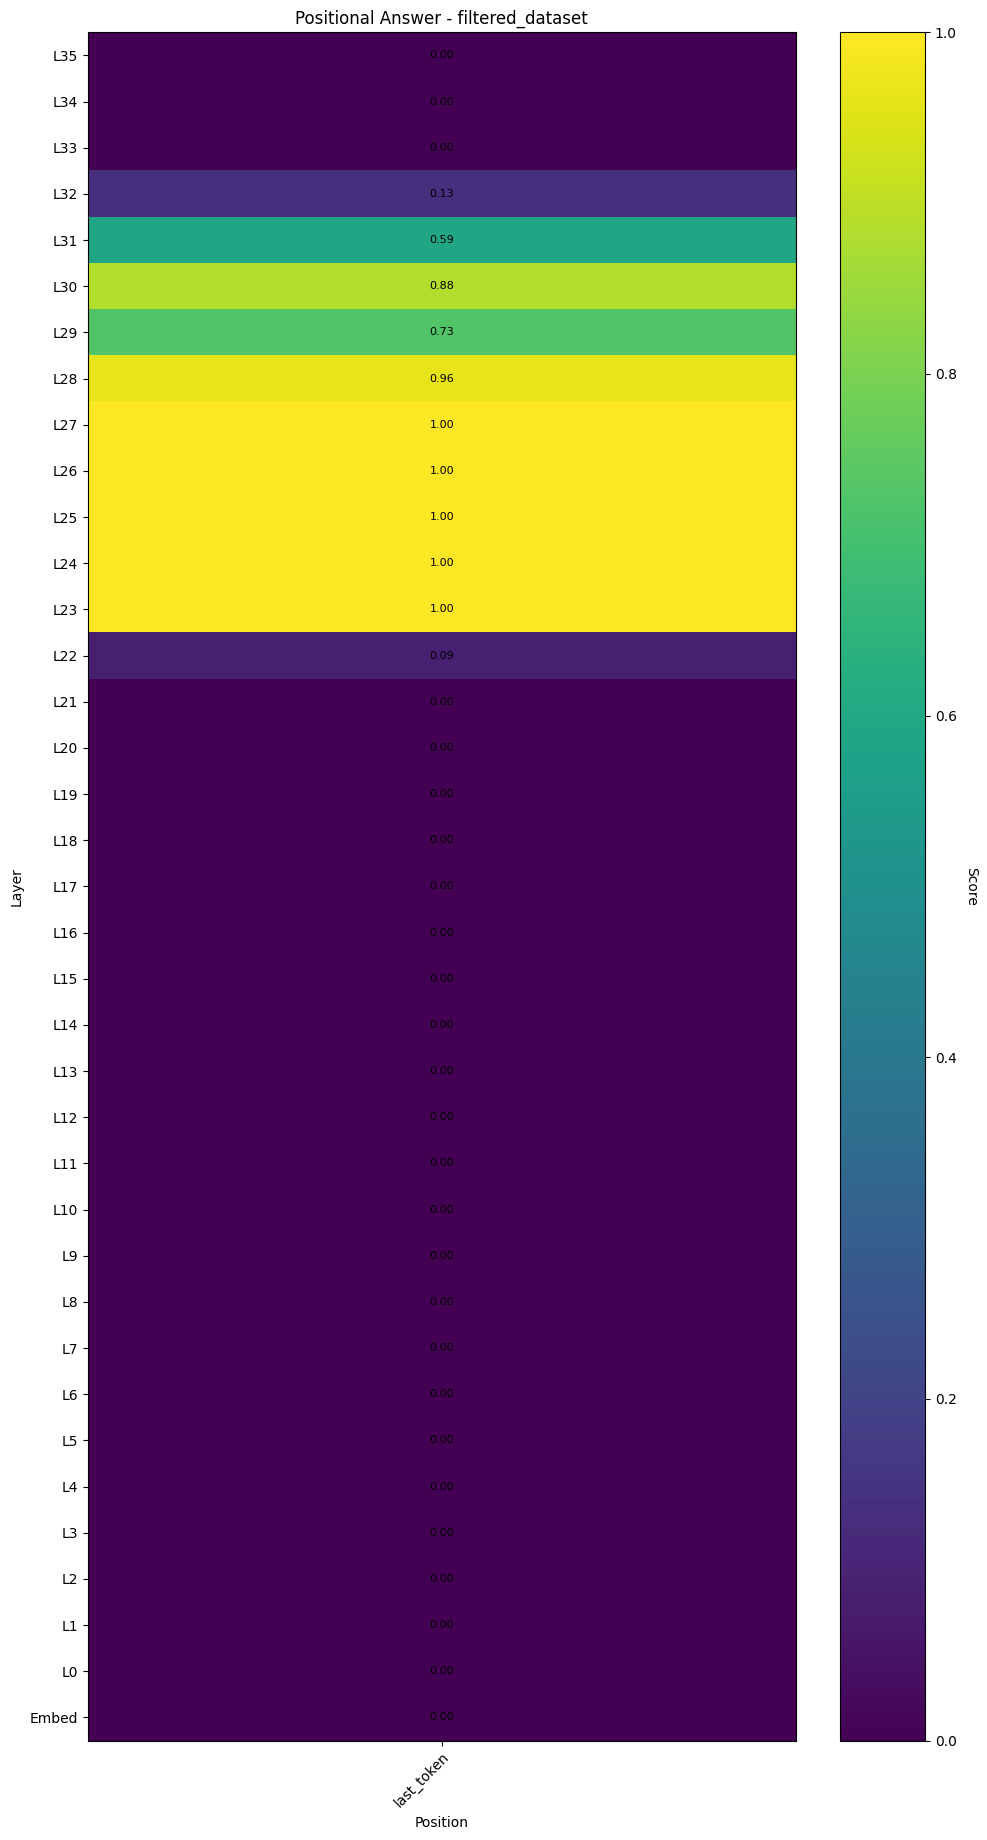

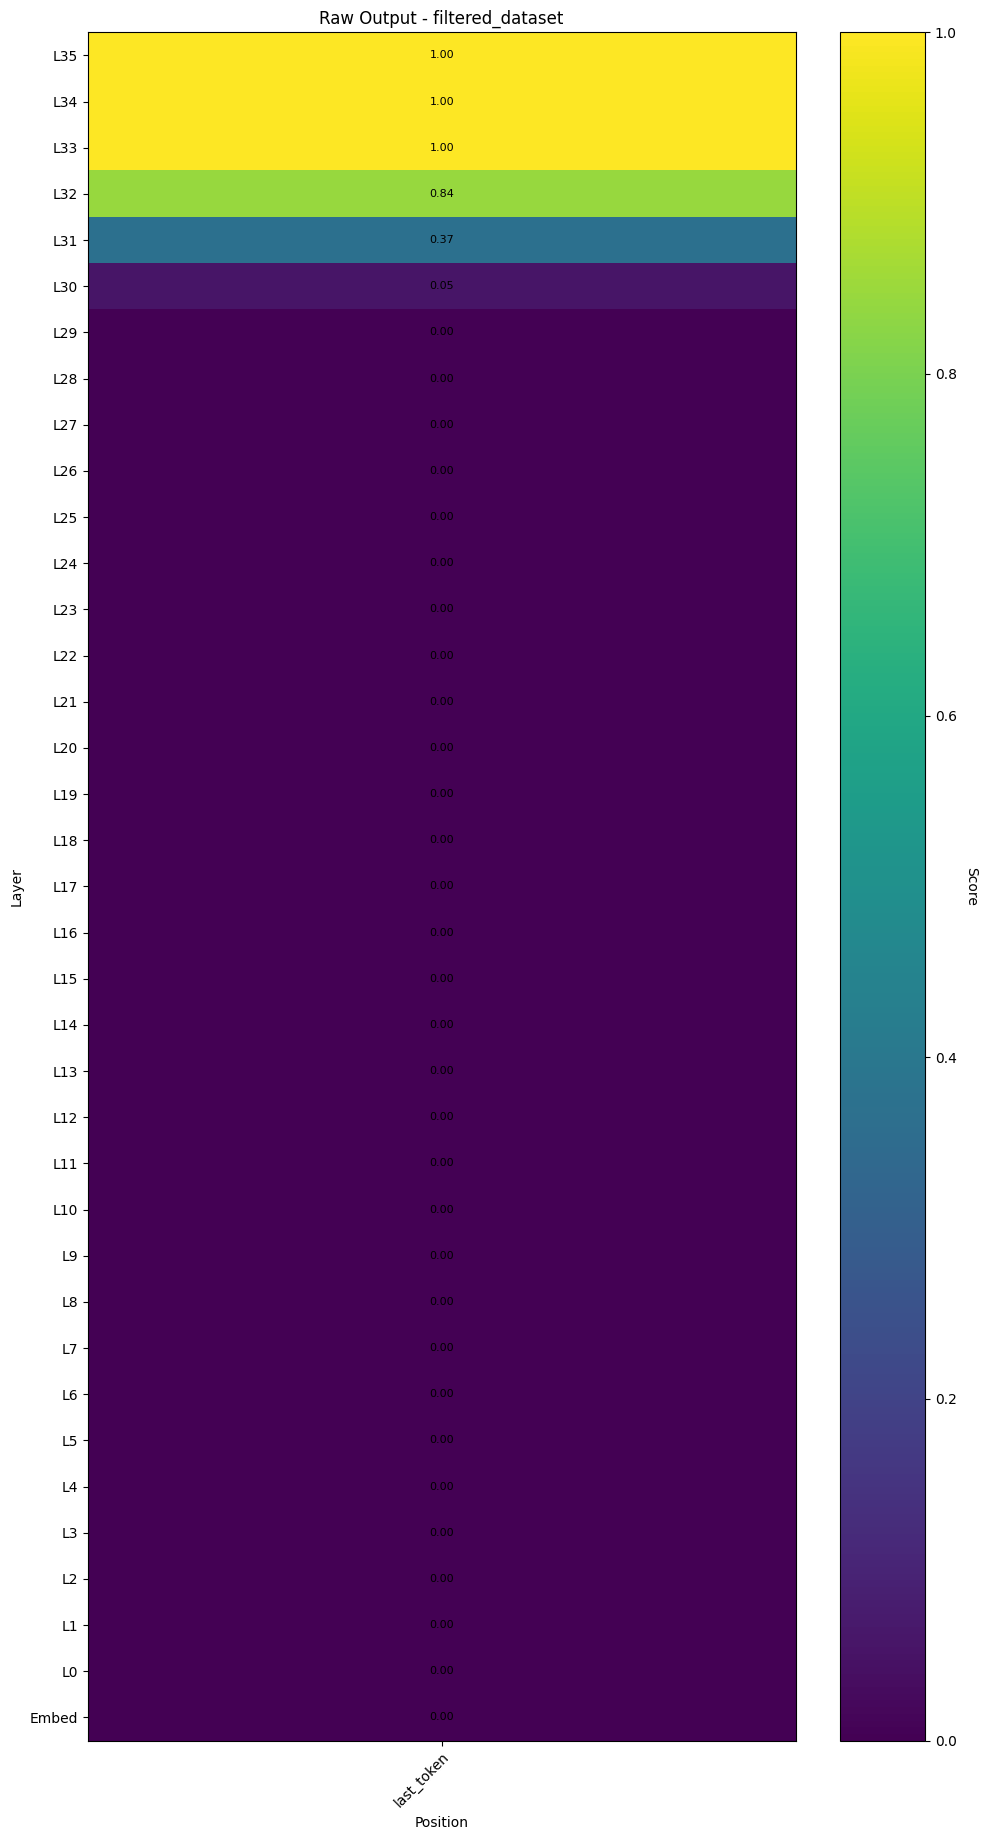

In [12]:
# Run the interchange score heatmap experiment
target_variable_groups = [tuple([v]) for v in EXPERIMENT_CONFIG["target_variables"]]

print("Running interchange interventions...")
print(f"Target variables: {EXPERIMENT_CONFIG['target_variables']}")
print(f"Dataset size: {len(filtered_dataset)}")
print(f"Batch size: {EXPERIMENT_CONFIG['batch_size']}")
print()

result = run_interchange_score_heatmap(
    causal_model=causal_model,
    interchange_targets=targets,
    dataset_path=str(filtered_path),
    pipeline=pipeline,
    target_variable_groups=target_variable_groups,
    batch_size=EXPERIMENT_CONFIG["batch_size"],
    output_dir=str(results_dir),
    metric=checker,
    verbose=True,
)

## Part 7: Interpret Results

The **interchange score** measures how well patching at a given layer causes the model's output to match the causal model's prediction for that intervention.

- Score = 1.0: Patching perfectly transfers the causal variable
- Score = 0.0: Patching has no effect on the output

Expected findings:
- `positional_answer`: Should peak in **middle layers** (23-26) where positional lookup happens
- `raw_output`: Should peak in **final layers** (32-35) where the semantic answer is computed

## Interpretation

The results show where different types of information are represented in the model:

1. **`positional_answer`**: If this peaks in middle layers, the model is computing "which position to look up" early in processing. This supports the positional hypothesis.

2. **`raw_output`**: If this peaks in later layers, the actual semantic answer is computed later, after the positional lookup is resolved.

This experiment demonstrates **causal abstraction** - we can map high-level causal variables (like "positional answer" vs "semantic answer") onto specific locations in the neural network and verify they behave as the causal model predicts.
